<a href="https://colab.research.google.com/github/sakongmyoungheun/homework/blob/main/%ED%95%9C%EA%B5%AD%EC%96%B4_%EC%9E%84%EB%B2%A0%EB%94%A9_%EA%B3%BC%EC%A0%9C.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [135]:
import json
import pandas as pd
import numpy as np
import re
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import skipgrams
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.layers import Embedding, Reshape, Activation, Input, Dot
from tensorflow.keras.utils import plot_model
import gensim

In [106]:
# 데이터를 가지고 오는 과정
file_path = '/content/뉴스_정치_training.json'

with open(file_path, 'r') as file:
    data = json.load(file)

print(len(data))

35486


In [107]:
# 가져온 데이터가 가지고 있는 key 확인
data_key = list(data[0].keys())
print(data_key)

['id', 'doc_type', 'doc_id', 'title', 'date', 'publisher', 'reg_no', 'ipc', 'field', 'subfield', 'sentence', 'subj_start', 'subj_end', 'obj_start', 'obj_end', 'subj_word', 'subj_prop', 'obj_word', 'obj_prop', 'relation']


In [108]:
# key를 바탕으로 데이터 프레임 생성
df = pd.DataFrame(data, columns=data_key)
df

,id,doc_type,doc_id,title,date,publisher,reg_no,ipc,field,subfield,sentence,subj_start,subj_end,obj_start,obj_end,subj_word,subj_prop,obj_word,obj_prop,relation
0,753680,뉴스,A220623150701,‘장준하 선생 아들’ 장호권씨 보궐선거서 새 광복회장 당선,2022-06-01,세계일보,,,정치,,장준하 선생의 아들 장호권 전 광복회 서울지부장이 신임 광복회장으로 선출됐다.,11,14,0,3,장호권,PS,장준하,PS,isChildOf
1,753681,뉴스,A220623150701,‘장준하 선생 아들’ 장호권씨 보궐선거서 새 광복회장 당선,2022-06-01,세계일보,,,정치,,장준하 선생의 아들 장호권 전 광복회 서울지부장이 신임 광복회장으로 선출됐다.,11,14,17,20,장호권,PS,광복회,OG,isMemberOf
2,753682,뉴스,A220623150701,‘장준하 선생 아들’ 장호권씨 보궐선거서 새 광복회장 당선,2022-06-01,세계일보,,,정치,,장준하 선생의 아들 장호권 전 광복회 서울지부장이 신임 광복회장으로 선출됐다.,11,14,31,35,장호권,PS,광복회장,CV,isA
3,753683,뉴스,A220623150701,‘장준하 선생 아들’ 장호권씨 보궐선거서 새 광복회장 당선,2022-06-01,세계일보,,,정치,,광복회는 지난 2월 횡령 의혹으로 물러난 김원웅 전 광복회장 후임을 뽑기 위한 보궐...,23,26,29,33,김원웅,PS,광복회장,CV,isA
4,753684,뉴스,A220623150701,‘장준하 선생 아들’ 장호권씨 보궐선거서 새 광복회장 당선,2022-06-01,세계일보,,,정치,,독립유공자인 장준하 선생의 장남인 장 회장은 1997∼2005년 민주평화통일자문회의...,7,10,0,5,장준하,PS,독립유공자,CV,isA
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
35481,1475958,뉴스,A220623219701,"“안 후보님, 단일화 문을 열어주십시오” 청년최고위원의 호소",2022-02-28,세계일보,,,정치,,그는 안 후보에게 “야권이 함께 모여 공동 비전을 수립하고 이를 실현할 단일 후보를...,40,45,78,81,단일 후보,TM,단일화,TM,isCausedBy
35482,1475959,뉴스,A220623219701,"“안 후보님, 단일화 문을 열어주십시오” 청년최고위원의 호소",2022-02-28,세계일보,,,정치,,"그는 “만에 하나, 야권의 공동 비전 실현을 위해 단일 후보로 세워진 분이 안철수의...",28,33,11,23,단일 후보,TM,야권의 공동 비전 실현,TM,hasAttribute
35483,1475960,뉴스,A220623219701,"“안 후보님, 단일화 문을 열어주십시오” 청년최고위원의 호소",2022-02-28,세계일보,,,정치,,"그는 “만에 하나, 야권의 공동 비전 실현을 위해 단일 후보로 세워진 분이 안철수의...",93,100,11,20,안철수의 비전,TM,야권의 공동 비전,TM,isToBe
35484,1475961,뉴스,A220623219704,이준석 “尹 경쟁력 충분… 단일화 꼭 필요한 요소 아냐”,2022-02-28,세계일보,,,정치,,이준석 국민의힘 대표가 지난 25일 오전 서울 중구 롯데호텔에서 열린 대한간호협회 ...,0,3,4,8,이준석,PS,국민의힘,OG,isMemberOf


In [109]:
# 학습에 필요한 부분이 sentence라고 판단해서 그 부분만 가지고 옴
df = df['sentence']
data = {'document': df}
data_df = pd.DataFrame(data)
data_df

,document
0,장준하 선생의 아들 장호권 전 광복회 서울지부장이 신임 광복회장으로 선출됐다.
1,장준하 선생의 아들 장호권 전 광복회 서울지부장이 신임 광복회장으로 선출됐다.
2,장준하 선생의 아들 장호권 전 광복회 서울지부장이 신임 광복회장으로 선출됐다.
3,광복회는 지난 2월 횡령 의혹으로 물러난 김원웅 전 광복회장 후임을 뽑기 위한 보궐...
4,독립유공자인 장준하 선생의 장남인 장 회장은 1997∼2005년 민주평화통일자문회의...
...,...
35481,그는 안 후보에게 “야권이 함께 모여 공동 비전을 수립하고 이를 실현할 단일 후보를...
35482,"그는 “만에 하나, 야권의 공동 비전 실현을 위해 단일 후보로 세워진 분이 안철수의..."
35483,"그는 “만에 하나, 야권의 공동 비전 실현을 위해 단일 후보로 세워진 분이 안철수의..."
35484,이준석 국민의힘 대표가 지난 25일 오전 서울 중구 롯데호텔에서 열린 대한간호협회 ...


In [110]:
# 데이터셋의 결측값을 제거하고 총 데이터셋의 갯수를 출력
data_df = data_df.dropna().reset_index(drop=True)
data_df

,document
0,장준하 선생의 아들 장호권 전 광복회 서울지부장이 신임 광복회장으로 선출됐다.
1,장준하 선생의 아들 장호권 전 광복회 서울지부장이 신임 광복회장으로 선출됐다.
2,장준하 선생의 아들 장호권 전 광복회 서울지부장이 신임 광복회장으로 선출됐다.
3,광복회는 지난 2월 횡령 의혹으로 물러난 김원웅 전 광복회장 후임을 뽑기 위한 보궐...
4,독립유공자인 장준하 선생의 장남인 장 회장은 1997∼2005년 민주평화통일자문회의...
...,...
35481,그는 안 후보에게 “야권이 함께 모여 공동 비전을 수립하고 이를 실현할 단일 후보를...
35482,"그는 “만에 하나, 야권의 공동 비전 실현을 위해 단일 후보로 세워진 분이 안철수의..."
35483,"그는 “만에 하나, 야권의 공동 비전 실현을 위해 단일 후보로 세워진 분이 안철수의..."
35484,이준석 국민의힘 대표가 지난 25일 오전 서울 중구 롯데호텔에서 열린 대한간호협회 ...


In [111]:
# 열을 기준으로 중복된 데이터를 제거
data_df = data_df.drop_duplicates(['document']).reset_index(drop=True)
print(len(data_df))

16944


In [112]:
# 데이터셋의 데이터 중 특수 문자를 제거
data_df['document'] = data_df['document'].apply(lambda x: re.sub(r'[^가-힣0-9\s]', '', x))
data_df

,document
0,장준하 선생의 아들 장호권 전 광복회 서울지부장이 신임 광복회장으로 선출됐다
1,광복회는 지난 2월 횡령 의혹으로 물러난 김원웅 전 광복회장 후임을 뽑기 위한 보궐...
2,독립유공자인 장준하 선생의 장남인 장 회장은 19972005년 민주평화통일자문회의 ...
3,3월21일 경제6단체장 오찬 간담회 윤석열 대통령이 요즘 즐겨 쓰는 단어가 모래주머니다
4,이명박 전 대통령은 취임 초 자신의 규제개혁에 대한 강한 의지를 전봇대 뽑기에 비유...
...,...
16939,이날 국민의당 김근태 최고위원은 사회관계망서비스에 이번 대선이 안철수 후보의 비전이...
16940,그는 우리 국민의당은 과학기술강국 555 초격차 전략이란 비전 아래 이번 대선을 치...
16941,그는 안 후보에게 야권이 함께 모여 공동 비전을 수립하고 이를 실현할 단일 후보를 ...
16942,그는 만에 하나 야권의 공동 비전 실현을 위해 단일 후보로 세워진 분이 안철수의 가...


In [113]:
# 학습할 데이터의 길이가 길기 때문에 문장이 150자 이하의 데이터를 필터
data_df = data_df[(data_df['document'].apply(lambda x: len(str(x))) > 100)]
data_df

,document
16,박홍근 더불어민주당 원내대표는 이날 선대위 회의에서 인사정보관리단이 국무회의에서 의...
21,이 대표는 예를 들어 선거 과정에서 문재인 대통령의 사진에 문 대통령의 의사가 포함...
22,이 대표는 박 위원장이 윤 대통령이 해당 동영상 제작을 묵인했다면 탄핵까지도 가능한...
23,이날 기자회견장에 함께 참석한 김웅 중앙선대위 공명선거본부장은 박 위원장의 발언은 ...
24,박 위원장은 앞서 이날 페이스북을 통해 윤석열이 윤 대통령으로 가장해 국민의힘 후...
...,...
16924,정의당 제공 심상정 정의당 대선 후보는 대선을 열흘 앞둔 27일 성전환 수술 후 강...
16925,더불어민주당 이재명오른쪽국민의힘 윤석열 후보가 지난 25일 오후 서울 마포구 상암동...
16931,이번 시험을 통해 국가우주개발국과 국방과학원은 정찰위성에 장착할 촬영기들로 지상 특...
16938,국민의힘 윤석열 대선 후보와 국민의당 안철수 대선 후보의 야권 단일화 가능성이 희박...


In [114]:
# 인덱스번호 리셋하는 과정
filtered_df = data_df.reset_index(drop=True)
filtered_df

,document
0,박홍근 더불어민주당 원내대표는 이날 선대위 회의에서 인사정보관리단이 국무회의에서 의...
1,이 대표는 예를 들어 선거 과정에서 문재인 대통령의 사진에 문 대통령의 의사가 포함...
2,이 대표는 박 위원장이 윤 대통령이 해당 동영상 제작을 묵인했다면 탄핵까지도 가능한...
3,이날 기자회견장에 함께 참석한 김웅 중앙선대위 공명선거본부장은 박 위원장의 발언은 ...
4,박 위원장은 앞서 이날 페이스북을 통해 윤석열이 윤 대통령으로 가장해 국민의힘 후...
...,...
5069,정의당 제공 심상정 정의당 대선 후보는 대선을 열흘 앞둔 27일 성전환 수술 후 강...
5070,더불어민주당 이재명오른쪽국민의힘 윤석열 후보가 지난 25일 오후 서울 마포구 상암동...
5071,이번 시험을 통해 국가우주개발국과 국방과학원은 정찰위성에 장착할 촬영기들로 지상 특...
5072,국민의힘 윤석열 대선 후보와 국민의당 안철수 대선 후보의 야권 단일화 가능성이 희박...


In [115]:
# 불용어 파일 불러오는 과정
stop_words = '/content/drive/MyDrive/자연어 처리/data/Unword.txt'
with open(stop_words, 'r', encoding='utf-8') as file:
    stop_words = file.read()

stop_words_list = stop_words.splitlines()

In [116]:
tokenized_doc = filtered_df['document'].apply(lambda x:x.split())
tokenized_doc = tokenized_doc.apply(lambda x: [text for text in x if text not in stop_words ])
tokenized_doc

0       [박홍근, 더불어민주당, 원내대표는, 이날, 선대위, 회의에서, 인사정보관리단이, ...
1       [대표는, 들어, 선거, 과정에서, 문재인, 대통령의, 사진에, 대통령의, 의사가,...
2       [대표는, 박, 위원장이, 윤, 대통령이, 해당, 동영상, 제작을, 묵인했다면, 탄...
3       [이날, 기자회견장에, 참석한, 김웅, 중앙선대위, 공명선거본부장은, 박, 위원장의...
4       [박, 위원장은, 앞서, 이날, 페이스북을, 통해, 윤석열이, 윤, 대통령으로, 가...
                              ...                        
5069    [정의당, 제공, 심상정, 정의당, 대선, 후보는, 대선을, 열흘, 앞둔, 27일,...
5070    [더불어민주당, 이재명오른쪽국민의힘, 윤석열, 후보가, 지난, 25일, 오후, 서울...
5071    [시험을, 통해, 국가우주개발국과, 국방과학원은, 정찰위성에, 장착할, 촬영기들로,...
5072    [국민의힘, 윤석열, 대선, 후보와, 국민의당, 안철수, 대선, 후보의, 야권, 단...
5073    [그는, 만에, 야권의, 비전, 실현을, 단일, 후보로, 세워진, 분이, 안철수의,...
Name: document, Length: 5074, dtype: object

In [117]:
tokenized_doc = tokenized_doc.to_list()
len(tokenized_doc)

5074

In [118]:
tokenizer = Tokenizer()
tokenizer.fit_on_texts(tokenized_doc)

word2idx = tokenizer.word_index
# print(word2idx)
word2idx = {value : key for key, value in word2idx.items()}
# print(word2idx)
encoded = tokenizer.texts_to_sequences(tokenized_doc)

In [119]:
vocab_size = len(word2idx)
print(f'단어 사전의 크기 : {vocab_size}')

단어 사전의 크기 : 40778


In [120]:
print(encoded[0])

[371, 7, 66, 3, 58, 308, 15205, 3618, 8679, 4582, 3619, 2933, 1170, 15206, 641, 1271, 15207, 1715, 3620, 15208, 25, 1081]


In [121]:
skip_grams = [skipgrams(sample, vocabulary_size=vocab_size, window_size=10) for sample in encoded[:5]]
print(f'전체 샘플 수 : {len(skip_grams)}')

전체 샘플 수 : 5


In [122]:
pairs, labels = skip_grams[0][0], skip_grams[0][1]
print(f'3 pairs : {pairs[:3]}')
print(f'3 labels : {labels[:3]}')

3 pairs : [[1715, 2977], [3619, 3620], [4582, 19921]]
3 labels : [0, 1, 0]


In [123]:
print(len(pairs))
print(len(labels))

660
660


In [124]:
for i in range(5):
    print('({:s}({:d}),{:s}({:d})) -> {:d}'.format(
        word2idx[pairs[i][0]], pairs[i][0],
        word2idx[pairs[i][1]], pairs[i][1],
        labels[i]
    ))

(받아야(1715),서울에(2977)) -> 0
(대법원(3619),초유의(3620)) -> 1
(국무총리는(4582),찍고(19921)) -> 0
(의결되면(8679),국무총리는(4582)) -> 1
(선대위(58),데는(5656)) -> 0


In [125]:
training_daraset = [skipgrams(sample, vocabulary_size=vocab_size, window_size=10) for sample in encoded[:5000]]
len(training_daraset)

5000

In [126]:
# 중심 단어를 위한 임베딩 테이블
embedding_dim = 100

w_inputs = Input(shape=(1,), dtype='int32')
word_embedding = Embedding(vocab_size, embedding_dim)(w_inputs)

c_inputs = Input(shape=(1,), dtype='int32')
context_embedding = Embedding(vocab_size, embedding_dim)(c_inputs)

In [127]:
dot_product =Dot(axes=2)([word_embedding, context_embedding])
dot_product =Reshape((1,), input_shape=(1,1))(dot_product)
output = Activation('sigmoid')(dot_product)

model = Model(inputs=[w_inputs, c_inputs], outputs=output)
model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_1 (InputLayer)        [(None, 1)]                  0         []                            
                                                                                                  
 input_2 (InputLayer)        [(None, 1)]                  0         []                            
                                                                                                  
 embedding (Embedding)       (None, 1, 100)               4077800   ['input_1[0][0]']             
                                                                                                  
 embedding_1 (Embedding)     (None, 1, 100)               4077800   ['input_2[0][0]']             
                                                                                              

In [128]:
model.compile(loss='binary_crossentropy', optimizer='adam')

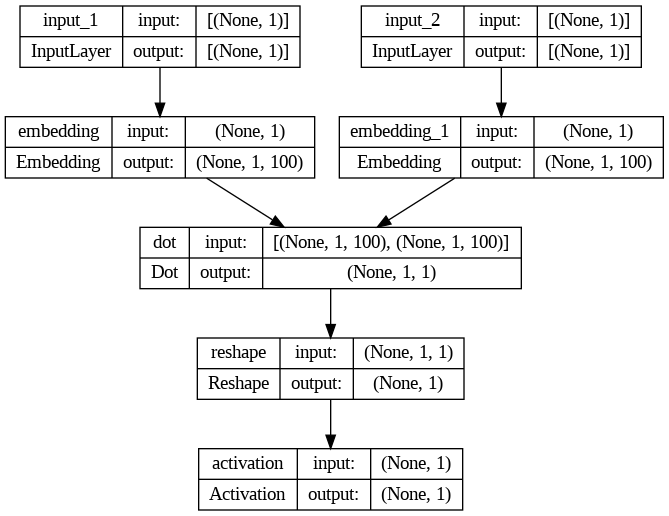

In [129]:
plot_model(model, to_file='model.png', show_shapes=True, show_layer_names=True)

In [130]:
for epoch in range(150):
    loss = 0
    for _, elem in enumerate(skip_grams):
        first_elem = np.array(list(zip(*elem[0]))[0], dtype='int32')
        second_elem = np.array(list(zip(*elem[0]))[1], dtype='int32')
        labels = np.array(elem[1], dtype='int32')
        X = [first_elem, second_elem]
        Y = labels
        loss += model.train_on_batch(X,Y)
    print('Epoch' , epoch+1 , 'Loss' , loss)

Epoch 1 Loss 3.4657533764839172
Epoch 2 Loss 3.4557275772094727
Epoch 3 Loss 3.4458190202713013
Epoch 4 Loss 3.435115694999695
Epoch 5 Loss 3.423168361186981
Epoch 6 Loss 3.409570038318634
Epoch 7 Loss 3.393951117992401
Epoch 8 Loss 3.3759779930114746
Epoch 9 Loss 3.3553518056869507
Epoch 10 Loss 3.331806182861328
Epoch 11 Loss 3.305108606815338
Epoch 12 Loss 3.275061309337616
Epoch 13 Loss 3.241504728794098
Epoch 14 Loss 3.204318046569824
Epoch 15 Loss 3.1634217500686646
Epoch 16 Loss 3.1187771558761597
Epoch 17 Loss 3.0703883171081543
Epoch 18 Loss 3.018301486968994
Epoch 19 Loss 2.9626054167747498
Epoch 20 Loss 2.9034306406974792
Epoch 21 Loss 2.8409470915794373
Epoch 22 Loss 2.7753618955612183
Epoch 23 Loss 2.7069169878959656
Epoch 24 Loss 2.635885000228882
Epoch 25 Loss 2.562564969062805
Epoch 26 Loss 2.4872786700725555
Epoch 27 Loss 2.4103658497333527
Epoch 28 Loss 2.3321787118911743
Epoch 29 Loss 2.2530767619609833
Epoch 30 Loss 2.1734221279621124
Epoch 31 Loss 2.09357351064682


In [131]:
# Word2Vec 모델을 학습시키고 학습된 모델을 활용하여 단어간 유사도 측정
f = open('vectors.txt', 'w')
f.write('{} {}\n'.format(vocab_size, embedding_dim))
vectors = model.get_weights()[0]
print(vectors)
print(len(vectors))

for word ,i in tokenizer.word_index.items():
    f.write('{} {} \n'.format(word, ' '.join(map(str, list(vectors[i-1, :])))))
f.close()

[[-0.00093529  0.03103269  0.03227443 ... -0.01691817 -0.03247702
   0.03165159]
 [-0.2740843   0.24220702 -0.2473979  ... -0.1994066  -0.2809441
   0.2641341 ]
 [ 0.01181994  0.04606785  0.00660627 ... -0.01736088  0.02715806
   0.00940417]
 ...
 [ 0.03310685  0.01908047 -0.03970975 ... -0.01887338 -0.00942311
  -0.00927571]
 [-0.02469602  0.0154903   0.01052871 ...  0.00860823 -0.03217497
  -0.03000258]
 [ 0.01521998  0.01246657  0.03819208 ... -0.0110232  -0.00509721
   0.00918833]]
40778


In [136]:
w2v = gensim.models.KeyedVectors.load_word2vec_format('./vectors.txt', binary=False)

In [139]:
w2v.most_similar(positive=['정치'])

[('것은', 0.4305790066719055),
 ('팬덤이자', 0.3770866394042969),
 ('거듭되자', 0.37186381220817566),
 ('받았는데', 0.3691404163837433),
 ('전망도', 0.3663751780986786),
 ('시행령이', 0.36477014422416687),
 ('동의할', 0.36370643973350525),
 ('주식을', 0.35663503408432007),
 ('띄운', 0.35425126552581787),
 ('무속인에게', 0.3522588014602661)]